In [76]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold, RepeatedKFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
import time
import cudf
from cuml.ensemble import RandomForestRegressor as cuRF
import math
from tqdm import tqdm
import xgboost as xgb

#### Output file

In [77]:
sourceFile = open("gpu_logs/ensemble_banes.txt", 'w')

### Load the data

In [78]:
df = pd.read_csv("data/BANES_v2.csv", parse_dates=['time'])
number_of_houses = df['location'].nunique()
#num_samples_per_house = 35136
df.reset_index(drop=True, inplace=True)
## Leaving the first house (public building out) due to its different profile
#df = df.iloc[35136:, [0, 2, 1]].reset_index(drop=True)
df

,location,time,energy,AirTemp,RelativeHumidity,Dni
0,## OLD Paulton Library Electricity Supply 1,2008-06-14 00:30:00+00:00,0.080,9.1,0.829,0.0
1,## OLD Paulton Library Electricity Supply 1,2008-06-14 01:00:00+00:00,0.070,8.9,0.836,0.0
2,## OLD Paulton Library Electricity Supply 1,2008-06-14 01:30:00+00:00,0.080,8.7,0.844,0.0
3,## OLD Paulton Library Electricity Supply 1,2008-06-14 02:00:00+00:00,0.070,8.5,0.852,0.0
4,## OLD Paulton Library Electricity Supply 1,2008-06-14 02:30:00+00:00,0.080,8.3,0.860,0.0
...,...,...,...,...,...,...
7759963,Westfield Childrens Centre (Now Schools Respon...,2020-02-07 22:00:00+00:00,0.126,8.6,0.904,0.0
7759964,Westfield Childrens Centre (Now Schools Respon...,2020-02-07 22:30:00+00:00,0.124,9.1,0.896,0.0
7759965,Westfield Childrens Centre (Now Schools Respon...,2020-02-07 23:00:00+00:00,0.158,9.5,0.899,0.0
7759966,Westfield Childrens Centre (Now Schools Respon...,2020-02-07 23:30:00+00:00,0.142,9.7,0.914,0.0


In [79]:
df = df[df['time'] >= '2017-01-01']
df

,location,time,energy,AirTemp,RelativeHumidity,Dni
80112,## OLD Paulton Library Electricity Supply 1,2018-01-01 00:30:00+00:00,0.000,5.5,0.815,0.0
80113,## OLD Paulton Library Electricity Supply 1,2018-01-01 01:00:00+00:00,0.000,5.5,0.804,0.0
80114,## OLD Paulton Library Electricity Supply 1,2018-01-01 01:30:00+00:00,0.000,5.5,0.794,0.0
80115,## OLD Paulton Library Electricity Supply 1,2018-01-01 02:00:00+00:00,0.000,5.4,0.784,0.0
80116,## OLD Paulton Library Electricity Supply 1,2018-01-01 02:30:00+00:00,0.000,5.4,0.774,0.0
...,...,...,...,...,...,...
7759963,Westfield Childrens Centre (Now Schools Respon...,2020-02-07 22:00:00+00:00,0.126,8.6,0.904,0.0
7759964,Westfield Childrens Centre (Now Schools Respon...,2020-02-07 22:30:00+00:00,0.124,9.1,0.896,0.0
7759965,Westfield Childrens Centre (Now Schools Respon...,2020-02-07 23:00:00+00:00,0.158,9.5,0.899,0.0
7759966,Westfield Childrens Centre (Now Schools Respon...,2020-02-07 23:30:00+00:00,0.142,9.7,0.914,0.0


In [80]:
#trunc = lambda x: math.trunc(10000 * x) / 10000
#df_trunc = pd.DataFrame(df['Energy']).applymap(trunc)
#df = pd.concat([df.iloc[:, 0:-1], df_trunc], axis=1)
#df

### Auxiliary functions

In [81]:
def plot_results(preds: np.array, actuals: np.array, title: str):
    
    plt.scatter(actuals, preds, c='b', label='predicted')
    plt.xlabel('actual')
    plt.ylabel('predicted')
    plt.title(title)
    plt.xlim(0, plt.xlim()[1])
    plt.ylim(0, plt.ylim()[1])
    _ = plt.plot([0, 100], [0, 100], '--r', label='y=x')
    plt.legend()
    plt.show()
    
    
def performance_metrics(preds: np.array, actuals: np.array, filename):

    # calculate performance metrics
    
    mse = mean_squared_error(actuals, preds)
    wape = np.sum(np.abs(preds - actuals)) / np.sum(np.abs(actuals)) * 100
    r2 = r2_score(actuals, preds)
    
    # print performance metrics
    print('MSE: %.4f' % mse, file=filename)
    print('WAPE: %.4f' % wape, file=filename)
    print('R2: %.4f' % r2, file=filename)
    return mse, wape, r2

#@jit(target_backend='cuda')
def build_model(estimator, X_train: np.array, y_train: np.array, X_test: np.array):
    
    model = estimator
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    return model, preds

def validate(estimator, X_train, y_train):
    scores = cross_validate(estimator, X_train, y_train, scoring=['r2', 'neg_mean_squared_error'])
    return scores
    

In [82]:
def total_averaged_metrics(metrics_list, filename):
    
    print("Total Averaged MSE: {}".format(np.round(sum(i for i, j, k in metrics_list)/len(metrics_list),3)), file=filename)
    print("Total Averaged WAPE: {}".format(np.round(sum(j for i, j, k in metrics_list)/len(metrics_list),3)), file=filename)
    print("Total Averaged R2: {}".format(np.round(sum(k for i, j, k in metrics_list)/len(metrics_list),3)), file=filename)

def past_timesteps(df, number_of_timesteps):
    df = df.sort_values(by=['location', 'time'])
    for i in tqdm(range(1, (number_of_timesteps + 1))):
        df.loc[df['time'].shift(i) == df['time'] - pd.Timedelta(i * 30, 'm'), f"energy_lag_{i}"] = df['energy'].shift(i)
    print(df.columns)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

In [83]:
def normalize_training(X_train):
    scaler = MinMaxScaler(feature_range=(0,1))
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    return X_train, scaler

### Cross Validate

In [84]:
#scores = validate(xgb.XGBRegressor(seed=0), X_train, y_train)
#cv_mse = np.round(scores['test_neg_mean_squared_error'].mean() * (-1),4)
#cv_r2 = np.round(scores['test_r2'].mean(),5)
#print("CV MSE: {} ".format(cv_mse))
#print("CV R2: {} ".format(cv_r2))
#metrics_list.append((cv_mse,cv_rmse,cv_mae,mape,cv_r2))

## Leave 10 houses for test (demonstration)

In [85]:
number_of_timesteps = 12

In [86]:
df_new = past_timesteps(df, number_of_timesteps)
df_new

100%|██████████| 12/12 [00:00<00:00, 15.02it/s]


,location,time,energy,AirTemp,RelativeHumidity,Dni,energy_lag_1,energy_lag_2,energy_lag_3,energy_lag_4,energy_lag_5,energy_lag_6,energy_lag_7,energy_lag_8,energy_lag_9,energy_lag_10,energy_lag_11,energy_lag_12
0,## OLD Paulton Library Electricity Supply 1,2018-01-01 06:30:00+00:00,0.000,5.5,0.793,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,## OLD Paulton Library Electricity Supply 1,2018-01-01 07:00:00+00:00,0.000,5.4,0.814,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,## OLD Paulton Library Electricity Supply 1,2018-01-01 07:30:00+00:00,0.000,5.3,0.835,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,## OLD Paulton Library Electricity Supply 1,2018-01-01 08:00:00+00:00,0.000,5.2,0.857,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,## OLD Paulton Library Electricity Supply 1,2018-01-01 08:30:00+00:00,0.000,5.0,0.879,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2529019,Westfield Childrens Centre (Now Schools Respon...,2020-02-07 22:00:00+00:00,0.126,8.6,0.904,0.0,0.130,0.197,0.216,0.228,0.689,0.367,0.226,0.626,0.612,0.665,0.546,0.754
2529020,Westfield Childrens Centre (Now Schools Respon...,2020-02-07 22:30:00+00:00,0.124,9.1,0.896,0.0,0.126,0.130,0.197,0.216,0.228,0.689,0.367,0.226,0.626,0.612,0.665,0.546
2529021,Westfield Childrens Centre (Now Schools Respon...,2020-02-07 23:00:00+00:00,0.158,9.5,0.899,0.0,0.124,0.126,0.130,0.197,0.216,0.228,0.689,0.367,0.226,0.626,0.612,0.665
2529022,Westfield Childrens Centre (Now Schools Respon...,2020-02-07 23:30:00+00:00,0.142,9.7,0.914,0.0,0.158,0.124,0.126,0.130,0.197,0.216,0.228,0.689,0.367,0.226,0.626,0.612


In [87]:
df_new.isna().sum()

location            0
time                0
energy              0
AirTemp             0
RelativeHumidity    0
Dni                 0
energy_lag_1        0
energy_lag_2        0
energy_lag_3        0
energy_lag_4        0
energy_lag_5        0
energy_lag_6        0
energy_lag_7        0
energy_lag_8        0
energy_lag_9        0
energy_lag_10       0
energy_lag_11       0
energy_lag_12       0
dtype: int64

In [88]:
def test_leave_house_out(df, estimator, number_timesteps, num_houses_test, locations, filename):
    df_new = past_timesteps(df, number_timesteps)
    df_new['DayOfWeek'] = df_new['time'].dt.dayofweek
    df_new['Weekend'] = df_new['time'].dt.dayofweek.isin([5,6]).astype(int)
    df_new['Hour'] = df_new['time'].dt.hour
    test = df_new[df_new['location'].isin(locations)]
    train = df_new[~df_new['location'].isin(locations)]
    print("Train set: ", train.shape)
    print("Test set: ", test.shape)
    X_train = train.drop(['time', 'energy', 'location'], axis=1)
    X_test = test.drop(['time', 'energy', 'location'], axis=1)
    y_train = train['energy']
    y_test = test['energy']
    X_train_norm, scaler = normalize_training(X_train)
    X_test_norm = scaler.transform(X_test)

    model = estimator
    init = time.time()
    model.fit(X_train_norm, y_train)
    y_pred = model.predict(X_test_norm)
    end = time.time()
    print('Elapsed time: {:.4f} s'.format(end - init), file=filename)
    mse, wape, r2 = performance_metrics(y_pred, y_test.values.reshape(-1), filename)
    return mse, wape, r2, model

## Predict  10 folds with 10 random houses for test

In [89]:
num_houses_test = 10

In [90]:
#kf = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42) 
#locations = []
#for _, test_index in kf.split(df['location'].unique()):
#    locations.append(test_index)
#locations

In [91]:
locations = []
for i in range(10):
    l = np.random.choice(df['location'].unique(), size=num_houses_test, replace=False)
    locations.append(l)
locations

[array(['Stanton Drew Primary School (P272 HH)', 'Air cooled chiller 1',
        'First Floor Disabled WC Water Heater',
        'Ground & First Floor North - Power & Lighting',
        'Junior School Electricity - Corridor 1',
        'Twerton Infant School Electricity Supply',
        'Ground Floor South - Power',
        'Swallow Street Stores & Workshop Electri',
        'St Marks C of E School (HH)',
        'St Marks C of E School - Orchard Lodge'], dtype=object),
 array(['Infants School - Main School 2',
        'The Hollies Offices MSN (P272 HH)',
        '##Radstock Library (Town Council)',
        '##Northgate House Electricity Supply 2',
        '##Nothgate House Electricity Supply 3',
        'The Hollies Offices MSN Car Park Barrier',
        '##Weston Library Electricity Supply 1',
        'Pensford Primary Electricity Supply 2',
        'Ground Floor South - Lighting',
        'First Floor Kitchenenette Water Heater'], dtype=object),
 array(['Marksbury C of E Primary Sch

### Linear Regression

In [92]:
metrics_list_lr = []
print("\n----------------------------", file=sourceFile)
print("\nLinear Regression\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(10):
    print("\nIteration", i, file=sourceFile)
    mse, wape, r2, model_lr = test_leave_house_out(df, LinearRegression(), number_of_timesteps, num_houses_test, locations[i], sourceFile)
    metrics_list_lr.append((mse, wape, r2))

100%|██████████| 12/12 [00:00<00:00, 14.94it/s]


Train set:  (2186850, 21)
Test set:  (342174, 21)


100%|██████████| 12/12 [00:00<00:00, 15.12it/s]


Train set:  (2135308, 21)
Test set:  (393716, 21)


100%|██████████| 12/12 [00:00<00:00, 13.94it/s]


Train set:  (2038227, 21)
Test set:  (490797, 21)


100%|██████████| 12/12 [00:00<00:00, 14.29it/s]


Train set:  (2235271, 21)
Test set:  (293753, 21)


100%|██████████| 12/12 [00:00<00:00, 13.98it/s]


Train set:  (2090811, 21)
Test set:  (438213, 21)


100%|██████████| 12/12 [00:00<00:00, 13.84it/s]


Train set:  (2144463, 21)
Test set:  (384561, 21)


100%|██████████| 12/12 [00:00<00:00, 13.96it/s]


Train set:  (2200422, 21)
Test set:  (328602, 21)


100%|██████████| 12/12 [00:00<00:00, 14.05it/s]


Train set:  (2072535, 21)
Test set:  (456489, 21)


100%|██████████| 12/12 [00:00<00:00, 13.61it/s]


Train set:  (2231875, 21)
Test set:  (297149, 21)


100%|██████████| 12/12 [00:00<00:00, 13.65it/s]


Train set:  (2134648, 21)
Test set:  (394376, 21)


### XGBoost

In [93]:
metrics_list_xgb = []
print("\n----------------------------", file=sourceFile)
print("\nXGBoost\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(10):
    print("\nIteration", i, file=sourceFile)
    mse, wape, r2, model_xgb = test_leave_house_out(df, xgb.XGBRegressor(tree_method='gpu_hist', seed=0), number_of_timesteps, num_houses_test, locations[i], sourceFile)
    metrics_list_xgb.append((mse, wape, r2))

100%|██████████| 12/12 [00:00<00:00, 13.92it/s]


Train set:  (2186850, 21)
Test set:  (342174, 21)


100%|██████████| 12/12 [00:00<00:00, 15.07it/s]


Train set:  (2135308, 21)
Test set:  (393716, 21)


100%|██████████| 12/12 [00:00<00:00, 14.84it/s]


Train set:  (2038227, 21)
Test set:  (490797, 21)


100%|██████████| 12/12 [00:00<00:00, 13.15it/s]


Train set:  (2235271, 21)
Test set:  (293753, 21)


100%|██████████| 12/12 [00:00<00:00, 13.02it/s]


Train set:  (2090811, 21)
Test set:  (438213, 21)


100%|██████████| 12/12 [00:00<00:00, 15.21it/s]


Train set:  (2144463, 21)
Test set:  (384561, 21)


100%|██████████| 12/12 [00:00<00:00, 14.33it/s]


Train set:  (2200422, 21)
Test set:  (328602, 21)


100%|██████████| 12/12 [00:00<00:00, 12.87it/s]


Train set:  (2072535, 21)
Test set:  (456489, 21)


100%|██████████| 12/12 [00:00<00:00, 13.22it/s]


Train set:  (2231875, 21)
Test set:  (297149, 21)


100%|██████████| 12/12 [00:00<00:00, 13.23it/s]


Train set:  (2134648, 21)
Test set:  (394376, 21)


### Random Forest

In [94]:
metrics_list_rf = []
print("\n----------------------------", file=sourceFile)
print("\nRandom Forest\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(10):
    print("\nIteration", i, file=sourceFile)
    mse, wape, r2, model_rf = test_leave_house_out(df, cuRF(), number_of_timesteps, num_houses_test, locations[i], sourceFile)
    metrics_list_rf.append((mse, wape, r2))

100%|██████████| 12/12 [00:00<00:00, 13.18it/s]


Train set:  (2186850, 21)
Test set:  (342174, 21)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
100%|██████████| 12/12 [00:00<00:00, 15.10it/s]


Train set:  (2135308, 21)
Test set:  (393716, 21)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
100%|██████████| 12/12 [00:00<00:00, 12.82it/s]


Train set:  (2038227, 21)
Test set:  (490797, 21)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
100%|██████████| 12/12 [00:00<00:00, 12.96it/s]


Train set:  (2235271, 21)
Test set:  (293753, 21)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
100%|██████████| 12/12 [00:00<00:00, 12.81it/s]


Train set:  (2090811, 21)
Test set:  (438213, 21)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
100%|██████████| 12/12 [00:00<00:00, 14.12it/s]


Train set:  (2144463, 21)
Test set:  (384561, 21)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
100%|██████████| 12/12 [00:00<00:00, 13.70it/s]


Train set:  (2200422, 21)
Test set:  (328602, 21)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
100%|██████████| 12/12 [00:00<00:00, 12.86it/s]


Train set:  (2072535, 21)
Test set:  (456489, 21)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
100%|██████████| 12/12 [00:00<00:00, 12.92it/s]


Train set:  (2231875, 21)
Test set:  (297149, 21)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
100%|██████████| 12/12 [00:00<00:00, 14.87it/s]


Train set:  (2134648, 21)
Test set:  (394376, 21)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


## Averaged Metrics

In [95]:
print("\n\n\n", file=sourceFile)

In [96]:
print("\nLinear Regression", file=sourceFile)
total_averaged_metrics(metrics_list_lr, sourceFile)

In [97]:
print("\nXGBoost", file=sourceFile)
total_averaged_metrics(metrics_list_xgb, sourceFile)

In [98]:
print("\nRandom Forest", file=sourceFile)
total_averaged_metrics(metrics_list_rf, sourceFile)

### Feature Importance

In [99]:
print('Linear Regression\n')
for i,v in enumerate(model_lr.coef_):
    print('Feature: %0d, Score: %.5f' % (i,v))
print('XGBoost\n')
for i,v in enumerate(model_xgb.feature_importances_):
    print('Feature: %0d, Score: %.5f' % (i,v))

Linear Regression

Feature: 0, Score: -0.04383
Feature: 1, Score: 0.11495
Feature: 2, Score: 0.06466
Feature: 3, Score: 72.36419
Feature: 4, Score: -9.80069
Feature: 5, Score: -0.66345
Feature: 6, Score: 1.48634
Feature: 7, Score: -1.36788
Feature: 8, Score: -1.66638
Feature: 9, Score: 0.51090
Feature: 10, Score: 0.73527
Feature: 11, Score: -1.34809
Feature: 12, Score: -0.33717
Feature: 13, Score: -0.84557
Feature: 14, Score: 1.14397
Feature: 15, Score: -0.00531
Feature: 16, Score: -0.01811
Feature: 17, Score: -0.20511
XGBoost

Feature: 0, Score: 0.00033
Feature: 1, Score: 0.00022
Feature: 2, Score: 0.00024
Feature: 3, Score: 0.98613
Feature: 4, Score: 0.00184
Feature: 5, Score: 0.00070
Feature: 6, Score: 0.00082
Feature: 7, Score: 0.00075
Feature: 8, Score: 0.00082
Feature: 9, Score: 0.00075
Feature: 10, Score: 0.00080
Feature: 11, Score: 0.00071
Feature: 12, Score: 0.00067
Feature: 13, Score: 0.00057
Feature: 14, Score: 0.00103
Feature: 15, Score: 0.00102
Feature: 16, Score: 0.00000


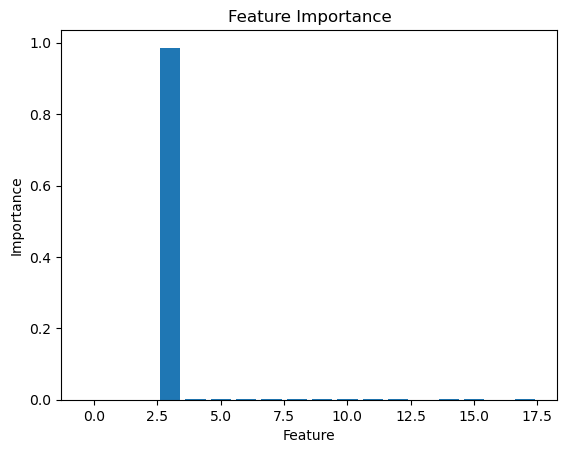

In [100]:
plt.bar(range(len(model_xgb.feature_importances_)),model_xgb.feature_importances_)
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

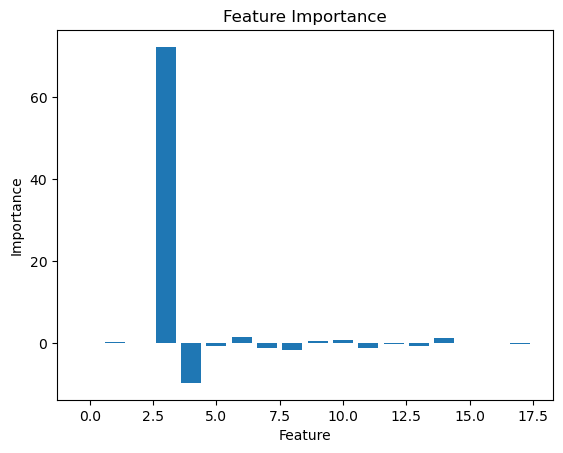

In [101]:
plt.bar(range(len(model_lr.coef_)),model_lr.coef_)
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

In [102]:
sourceFile.close()